In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code import FigureSingleCellData
from jtb_2022_code.figure_2_supplemental import figure_2_supplement_1_plot, figure_2_supplement_2_plot
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *

In [3]:
## LOAD ###
data = FigureSingleCellData()
data.do_projections()
data.load_pseudotime()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


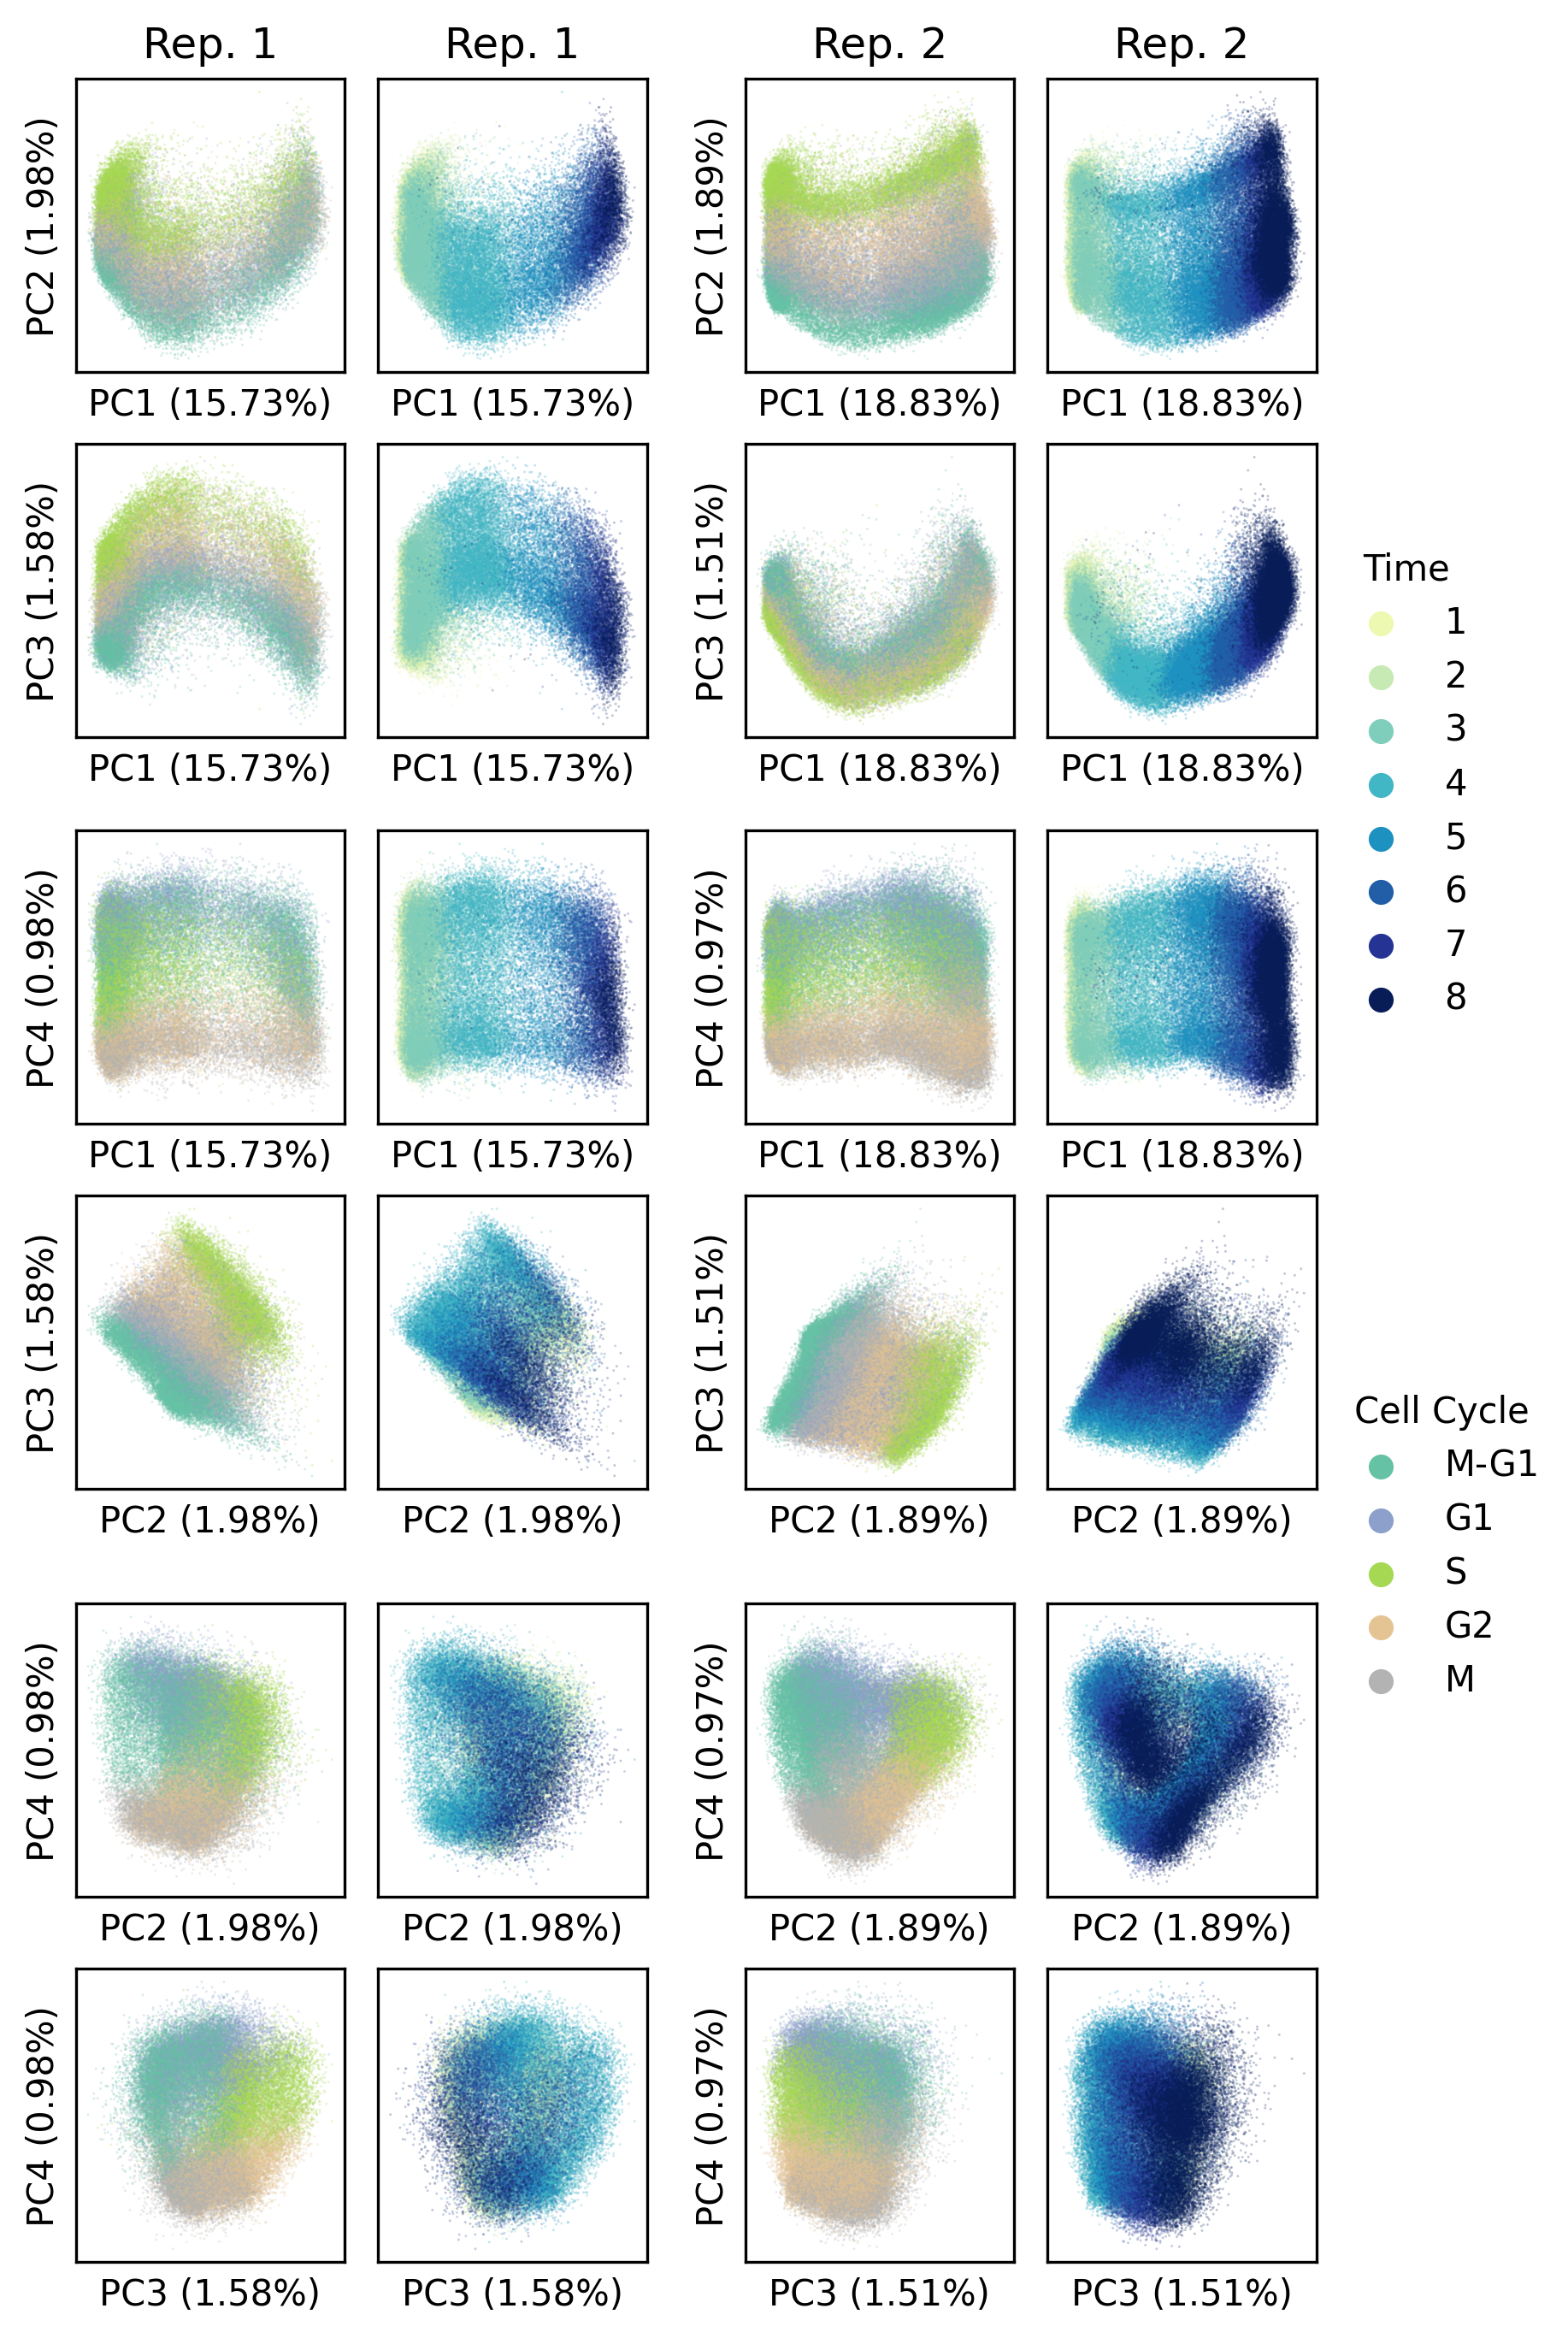

In [4]:
fig1 = figure_2_supplement_1_plot(data)

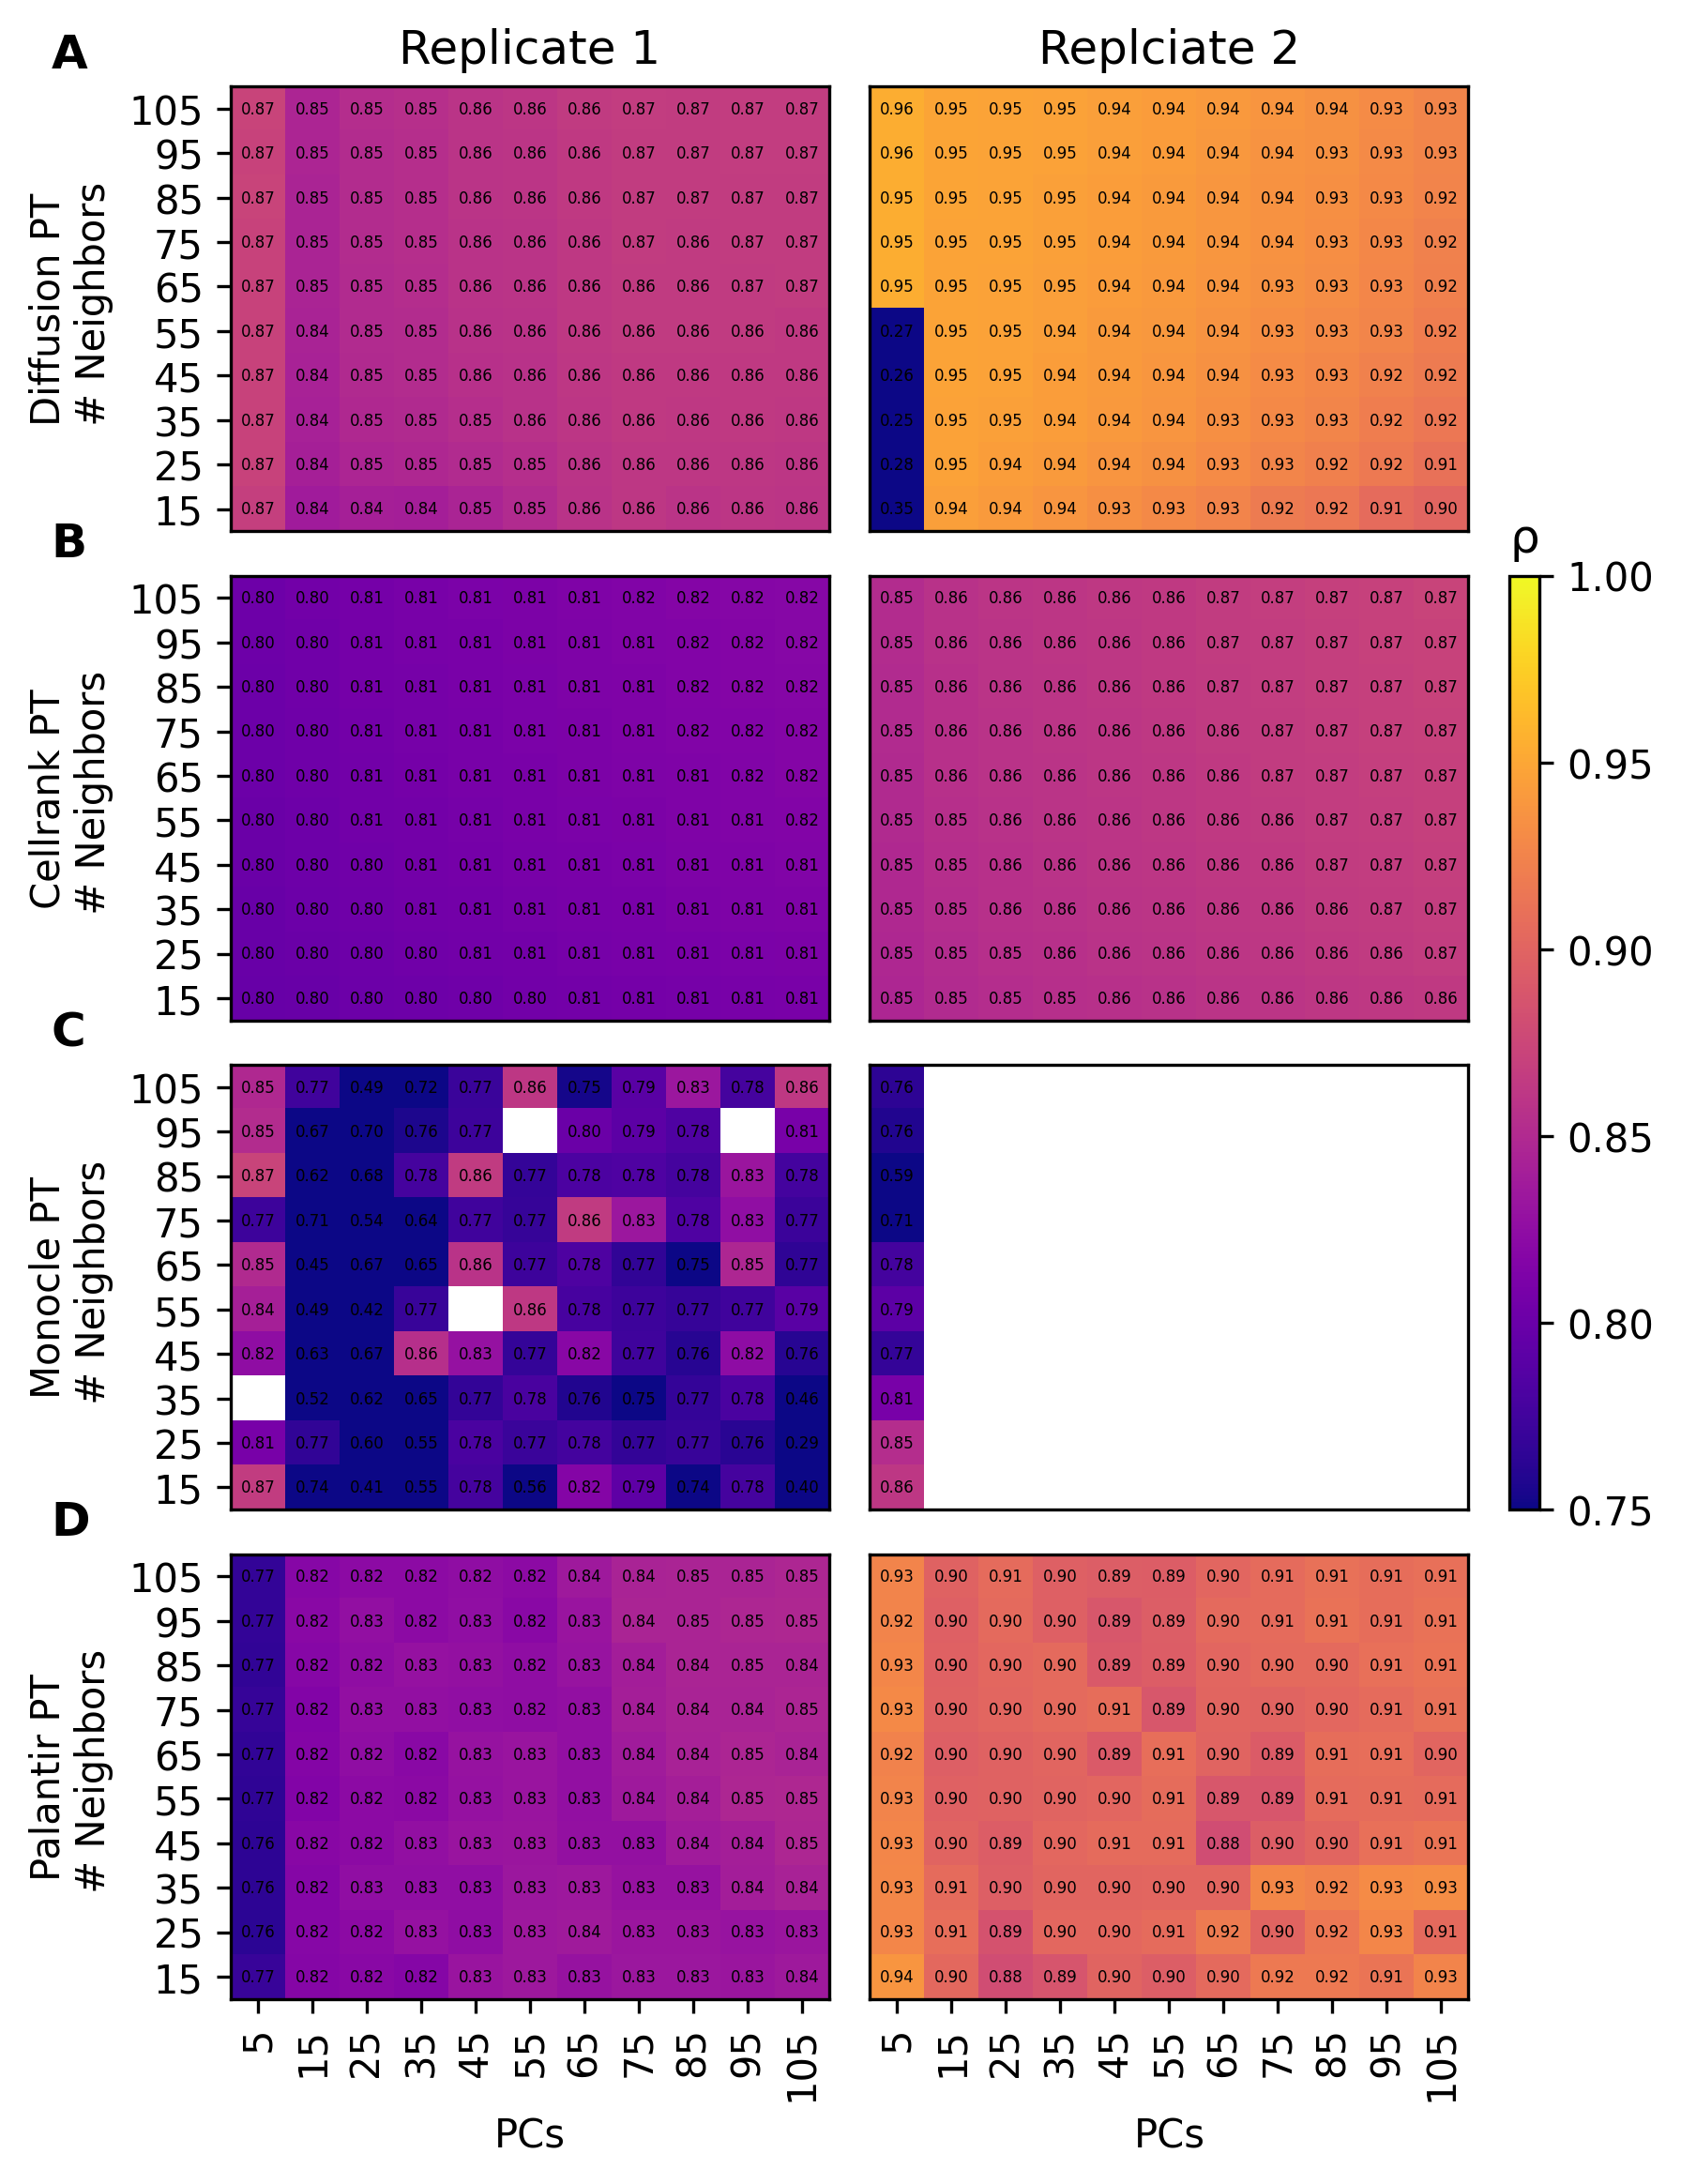

In [5]:
fig2 = figure_2_supplement_2_plot(data)

In [ ]:
data.expt_data[(1, "WT")]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
from scipy.stats import zscore, spearmanr
from scipy.sparse import issparse

def select_features_from_pc_stability(feature_data, loadings, tol=0.001, scale=True, debug=False):
    
    if scale:
        feature_data = zscore(feature_data)
    
    order_loadings = np.argsort(np.abs(loadings))[::-1]
    
    _order = np.arange(feature_data.shape[0]).reshape(-1, 1)
    _old_rho = 0
    for i in range(1, len(order_loadings)):        
        _select_features = order_loadings[0:i]
        
        new_loadings = np.zeros_like(loadings).reshape(-1, 1)
        new_loadings[_select_features, 0] = loadings[_select_features]
        
        pc = feature_data @ new_loadings
        
        _rho = spearmanr(_order, pc)[0]
        _delta_rho = np.abs(_rho - _old_rho)
                
        if _delta_rho <= tol:
            if debug:
                print(f"{i} features kept {_rho:.4f} [delta = {_delta_rho:.6f}]")
            
            return _select_features
        
        else:
            _order = pc
            _old_rho = _rho
        
    return order_loadings

def important_genes_pcs(adata, n_pcs=None, layer='X', tol=0.001):
    
    if 'PCs' not in adata.varm:
        raise ValueError("Run sc.pp.pca first")
        
    n_pcs = adata.varm['PCs'].shape[1] if n_pcs is None else n_pcs
    
    expression_data = adata.X if layer == "X" else adata.layers[layer]
    
    if issparse(expression_data):
        expression_data = expression_data.A
    
    expression_data = zscore(expression_data)
    
    key_genes = [
        select_features_from_pc_stability(expression_data,
                                          adata.varm['PCs'][:, i],
                                          scale=False,
                                          tol=tol,
                                          debug=i % 10 == 0)
        for i in range(n_pcs)
    ]
    
    key_genes = [adata.var_names[i].tolist() for i in key_genes]
    
    adata.uns['key_PC_genes'] = key_genes
    
    pcs_from_important(adata, n_pcs, layer)
    
    return adata

def pcs_from_important(adata, n_pcs=None, layer='X'):

    if 'PCs' not in adata.varm:
        raise ValueError("Run sc.pp.pca first")
        
    if 'key_PC_genes' not in adata.uns:
        raise ValueError("Run select_features_from_pc_stability first")
        
    n_pcs = len(adata.uns['key_PC_genes']) if n_pcs is None else n_pcs
    
    expression_data = adata.X if layer == "X" else adata.layers[layer]
    
    if issparse(expression_data):
        expression_data = expression_data.A
    
    expression_data = zscore(expression_data)
    
    adata.obsm['key_PC_genes'] = np.zeros((adata.X.shape[0], n_pcs), float)
    
    for i in tqdm.trange(n_pcs):
        _gene_idx = adata.var_names.isin(adata.uns['key_PC_genes'][i])
        
        _loadings = np.zeros(adata.X.shape[1])
        _loadings[_gene_idx] = adata.varm['PCs'][_gene_idx, i]
        
        adata.obsm['key_PC_genes'][:, i] = expression_data @ _loadings
        
    return adata

In [ ]:
import scanpy as sc
import anndata as ad
import gc

adata = ad.AnnData(data.expt_data[(1, "WT")].X.astype(float).A)
adata.var_names = data.expt_data[(1, "WT")].var_names.copy()
adata.obs_names = data.expt_data[(1, "WT")].obs_names.copy()

del data
gc.collect(2)

In [ ]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=2500)

In [ ]:
import scipy.sparse as sps
adata.X = sps.csr_matrix(adata.X)

In [ ]:
adata.write("/scratch/cj59/test_yeast_important_PCs.h5ad")

In [ ]:
sp_result = spearmanr(adata.obsm['key_PC_genes'], axis=0)

In [ ]:
sns.clustermap(np.abs(sp_result[0]), vmin=0, vmax=1)

In [ ]:
np.sum(np.cumsum(adata.uns['pca']['variance_ratio']) <= 0.75)

In [ ]:
important_genes_pcs(adata, n_pcs=np.sum(np.cumsum(adata.uns['pca']['variance_ratio']) <= 0.75))

In [ ]:
_n_total = np.zeros(len(adata.uns['key_PC_genes']), dtype=int)
_n_unique = np.zeros(len(adata.uns['key_PC_genes']), dtype=int)
_seen = set()

for i, g in enumerate(adata.uns['key_PC_genes']):
    _n_total[i] = len(g)
    _seen = _seen.union(g)
    _n_unique[i] = len(_seen) 

In [ ]:
np.cumsum(adata.uns['pca']['variance_ratio'])[0: 100]

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(6, 8))

axs[0, 0].plot(np.arange(len(_n_total)), _n_total, 
            marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
axs[0, 0].set_title("# Genes")
axs[1, 0].plot(np.arange(len(_n_total)), _n_unique, 
            marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
axs[1, 0].set_title("Cumulative # Genes")

axs[0, 1].plot(np.arange(len(_n_total)), np.cumsum(_n_total), 
            marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
axs[0, 1].set_title("Cumulative Unique Genes")
axs[1, 1].plot(np.arange(len(_n_total) - 1), np.diff(_n_unique), 
            marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
axs[1, 1].set_title("# Genes")

axs[2, 0].plot(np.arange(len(_n_total)), adata.uns['pca']['variance_ratio'][0:len(_n_total)], 
            marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
axs[2, 0].set_title("Var. Expl.")
axs[2, 1].plot(np.arange(len(_n_total)), np.cumsum(adata.uns['pca']['variance_ratio'])[0:len(_n_total)], 
            marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
axs[2, 1].set_title("Cumulative Var. Expl.")

fig.savefig("test.png")